# Imports and Loads

In [1]:
import pyspark

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1603703473778_0002,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import pyspark.sql.functions as F
from pyspark.sql import Row

from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
train_data_path = 's3://ny-taxi-emr/train.csv'
test_data_path = 's3://ny-taxi-emr/test.csv'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
train_data = spark.read.csv(train_data_path, header = True, inferSchema \
                           = True, mode="DROPMALFORMED")
test_data = spark.read.csv(test_data_path, header = True, inferSchema \
                          = True, mode="DROPMALFORMED")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The data consists of eight features:
    1. key
    2. fare_amount
    3. pickup_datetime
    4. pickup_longitude
    5. pickup_latitude
    6. dropoff_longitude
    7. dropoff_latitude
    8. passenger_count
    
**key** is for identification.

**fare_amount** is the target value we will be predicting for the test set.

Rest of the properties are the input features based on which we need to predict the fare amount.

# Basic Cleaning

In [5]:
print('Shape of train data', (train_data.count(), len(train_data.columns)))
print('Shape of test data', (test_data.count(), len(test_data.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Shape of train data (55423856, 8)
Shape of test data (9914, 7)

In [6]:
train_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:...|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:...|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:...|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|      

In [7]:
train_data.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [8]:
train_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)

**Create new columns based on datetime**

In [5]:
train_data = train_data.withColumn("pickup_datetime", F.to_timestamp(F.col("pickup_datetime"), "yyyy-MM-dd HH:mm:ss"))
train_data.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)

In [10]:
train_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 00:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 04:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [6]:
def create_date_columns():
    """
        Create new rows from pickup_datetime, 
        namely, date, day, hour, day_of_week, month and year
    """
    # Get datetime.date objects and create a new column pickup_date
    new_train_data = train_data.withColumn("pickup_date", F.to_date(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_day", F.dayofmonth(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_hour", F.hour(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_day_of_week", F.dayofweek(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_month", F.month(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_year", F.year(F.col("pickup_datetime")))
    
    return new_train_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
new_train_data = create_date_columns()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
new_train_data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|                 2|           6|       2009|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|           

**Check for null entries**

In [8]:
new_train_data.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in new_train_data.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|  0|          0|              0|               0|              0|              376|             376|              0|          0|         0|          0|                 0|           0|          0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+

**Drop rows with null values**

In [8]:
print('Length before removal', new_train_data.count())
new_train_data = new_train_data.filter(new_train_data.dropoff_longitude.isNotNull())
new_train_data = new_train_data.filter(new_train_data.dropoff_latitude.isNotNull())
print('Length after removal', new_train_data.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Length before removal 55423856
Length after removal 55423480

# Visualizations

### Fare Amount Data Distribution

In [16]:
print("Maximum Fare:{}\n Minimum Fare: {}".format(new_train_data.agg({"fare_amount": "max"}).collect()[0],\
      new_train_data.agg({"fare_amount": "min"}).collect()[0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Maximum Fare:Row(max(fare_amount)=93963.36)
 Minimum Fare: Row(min(fare_amount)=-300.0)

As we can see, there are negative fares as well as extremely high fares. While negative fares don't make any sense, based on data of NY Taxi base fares, we know that the base fare is 2.5. So, we remove all records who have fares less than 2.5. Also, we keep the upper limit as 100, based on intuition

In [9]:
train_data_fare_filtered = new_train_data.filter(F.col("fare_amount").between(2.5, 100))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
train_data_fare_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|               Mon|           6|       2009|
|2010-01-05 16:52:16|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|           

In [19]:
fig = plt.figure()
axes = plt.gca()

ranges = [2.5,5,10,15,20,30,40,50,60,70,80,90,100]

plt.xticks(ticks = ranges[1:], labels= ['2.5-5', '5-10', '10-15', '15-20', '20-30', '30-40', \
            '40-50', '50-60', '60-70','70-80', '80-90', '90-100'], rotation = 'vertical')
plt.title('Binned Fare (less than $100)')
plt.xlabel('Fare')
plt.ylabel('Number of records')

hist(axes, train_data_fare_filtered.select(F.col(("fare_amount"))), bins = ranges)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

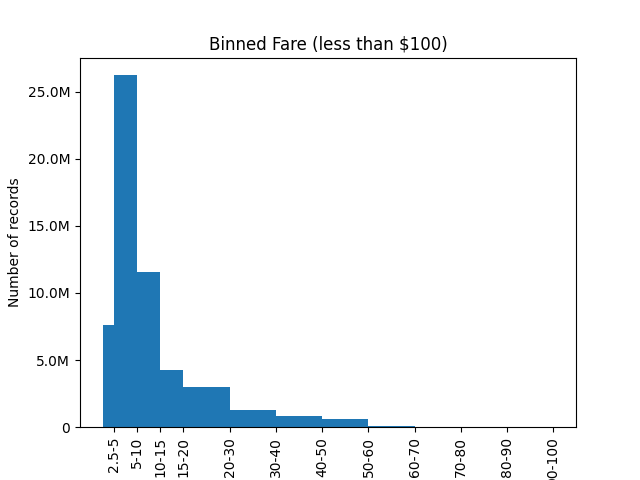

In [20]:
%matplot plt

We can see from the above plot that trips with fares in the range 2.5(base rate) to 15 is maximum and then there are some trips at the rate of 40-60 which can be some other kind of fixed rates.

### Passenger Count Distribution

In [21]:
print("Maximum Passengers:{}\n Minimum Passengers: {}".format(train_data_fare_filtered.agg({"passenger_count": "max"}).collect()[0],\
      train_data_fare_filtered.agg({"passenger_count": "min"}).collect()[0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Maximum Passengers:Row(max(passenger_count)=208)
 Minimum Passengers: Row(min(passenger_count)=0)

Again, we can see that the passenger count has high numbers as well as zero value which does not make sense. Again, we filter only those rows where count is [1,6], that is 7 seater cars

In [10]:
train_data_passenger_filtered = train_data_fare_filtered.filter(F.col("passenger_count").between(1,6))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
fig = plt.figure()
axes = plt.gca()

ranges = [1,2,3,4,5,6]

plt.xticks(rotation = 'vertical')
plt.title('Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Number of records')

hist(axes, train_data_passenger_filtered.select(F.col(("passenger_count"))), bins = ranges)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

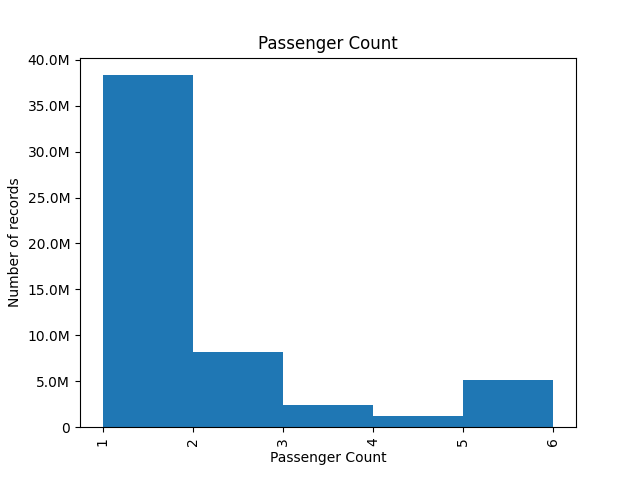

In [24]:
%matplot plt

### Analyzing Coordinates

In [25]:
print("Range of Pickup Latitude: ", train_data_passenger_filtered.agg({"pickup_latitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"pickup_latitude": "min"}).collect()[0])
print("Range of Pickup Longitude: ", train_data_passenger_filtered.agg({"pickup_longitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"pickup_longitude": "min"}).collect()[0])
print("Range of Dropoff Latitude: ", train_data_passenger_filtered.agg({"dropoff_latitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"dropoff_latitude": "min"}).collect()[0])
print("Range of Dropoff Longitude: ", train_data_passenger_filtered.agg({"dropoff_longitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"dropoff_longitude": "min"}).collect()[0])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Range of Pickup Latitude:  Row(max(pickup_latitude)=3408.789565) Row(min(pickup_latitude)=-3492.263768)
Range of Pickup Longitude:  Row(max(pickup_longitude)=3457.625683) Row(min(pickup_longitude)=-3442.059565)
Range of Dropoff Latitude:  Row(max(dropoff_latitude)=3537.132528) Row(min(dropoff_latitude)=-3547.886698)
Range of Dropoff Longitude:  Row(max(dropoff_longitude)=3457.62235) Row(min(dropoff_longitude)=-3442.024565)

Again, we see that latitude and longitude has extremities. Now, the central co-ordinate of NY are (40.771133, -73.974187). Using intuition, we keep the records whose co-ordinates are +/- 2 degrees from the centre

In [26]:
train_data_passenger_filtered.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

55202765

In [11]:
train_data_filtered = train_data_passenger_filtered.filter((F.col("pickup_latitude").between(38.5, 42.5)))
train_data_filtered = train_data_filtered.filter((F.col("dropoff_latitude").between(38.5, 42.5)))
train_data_filtered = train_data_filtered.filter((F.col("pickup_longitude").between(-76, -72)))
train_data_filtered = train_data_filtered.filter((F.col("dropoff_longitude").between(-76, -72)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
train_data_filtered.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

54057758

### Airport Fare Analysis

When we plot the pickups and drops for a small part of the dataset in Pandas, we see that there are many pickups and drops to and from airports. So, we try to confirm that using the co-ordinates of the airports and comparing the average fare for all trips against those for the airports. We do this so we can engineer features that differentiate trips to and from airports from other trips.

![](dropoffs.png)

![](pickups.png)

Coordinates of the three major airports in New York are as follows:

    1. Coordinates of Newark Airport = 40.6895° N, 74.1745° W

    2. Coordinates of JFK Airport = 40.6413° N, 73.7781° W

    3. Coordinates of La Guardia Airport = 40.7769° N, 73.8740° W

In [29]:
JFK = {
    'min_lng': -73.8352, 
    'min_lat': 40.6195, 
    'max_lng': -73.7401,  
    'max_lat': 40.6659
}

JFK_center=[40.6437, -73.7900]

# Get all pickups from JFK
train_data_JFK_pickup = train_data_filtered.filter(F.col("pickup_latitude").between(JFK['min_lat'], JFK['max_lat']))
train_data_JFK_pickup = train_data_JFK_pickup.filter(F.col("pickup_longitude").between(JFK['min_lng'], JFK['max_lng']))

print('Number of trips with pickups at JFK:', train_data_JFK_pickup.count())

# Get all dropoffs at JFK
train_data_JFK_drops = train_data_filtered.filter(F.col("dropoff_latitude").between(JFK['min_lat'], JFK['max_lat']))
train_data_JFK_drops = train_data_JFK_drops.filter(F.col("dropoff_longitude").between(JFK['min_lng'], JFK['max_lng']))

print('Number of trips with drops at JFK:', train_data_JFK_drops.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of trips with pickups at JFK: 827600
Number of trips with drops at JFK: 421014

In [30]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Pickup Fares')
plt.xlabel('Fare')

distplot(axes, train_data_JFK_pickup.select(F.col(("fare_amount"))), alpha = 0.6)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

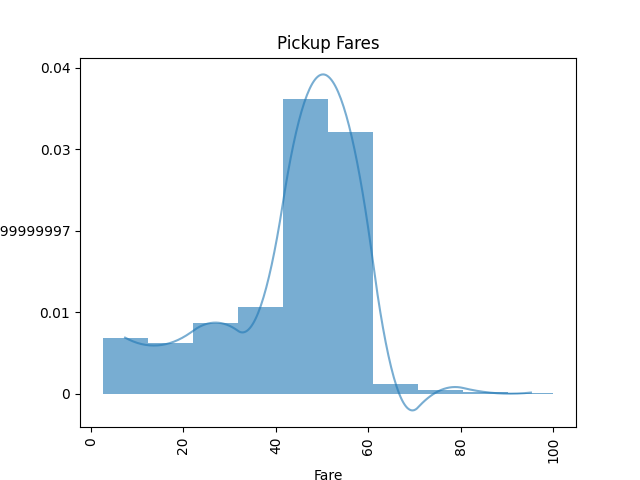

In [31]:
%matplot plt

In [32]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Dropoff Fares')
plt.xlabel('Fare')

distplot(axes, train_data_JFK_drops.select(F.col(("fare_amount"))), alpha = 0.6)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

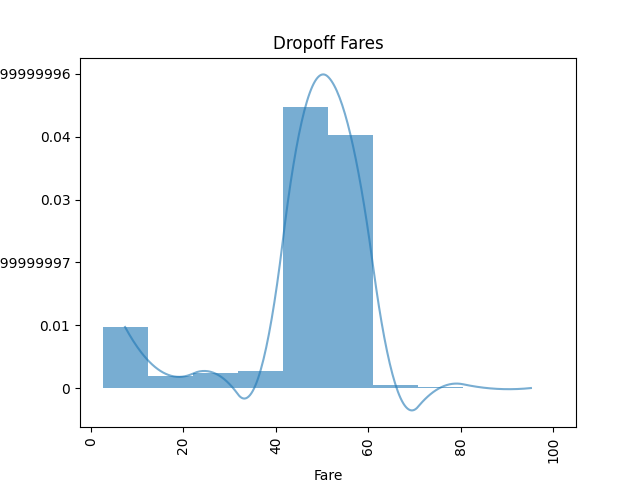

In [33]:
%matplot plt

We can see that the pickup and dropoff fares for JFK are more in the 40-60 range which can suggest fixed pricing. To confirm, let's compare this with average fare for all trips

In [34]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('All Fares')
plt.xlabel('Fare')

distplot(axes, train_data_filtered.select(F.col(("fare_amount"))), alpha = 0.6)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

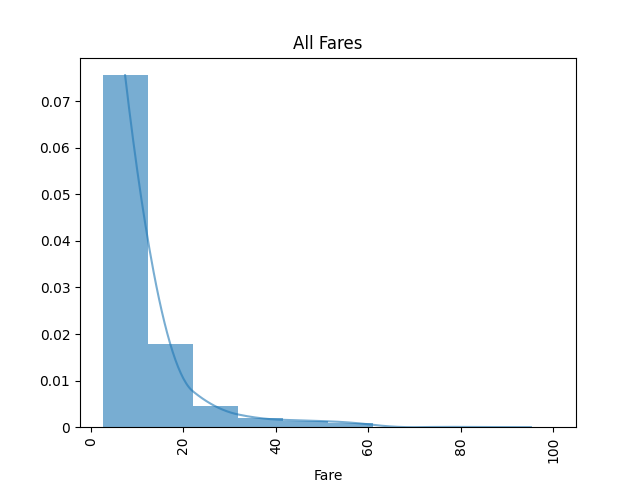

In [35]:
%matplot plt

Thus, the average fare is much higher when trips are related to airports. So, differentiating these records by feature engineering will help us build a better model as it will be able to differentiate and recognize the difference in pattern between airport trips and non-airport trips. So, we create features that specify whether a record (trip) is to any of the 3 airports

# Feature Engineering

### Airport Data

In [12]:
nyc_airports = {
    'JFK': {
        'min_lng': -73.8352, 
        'min_lat': 40.6195,
        'max_lng': -73.7401,  
        'max_lat': 40.6659
    },     
    'EWR': {
        'min_lng': -74.1925,
        'min_lat': 40.6700, 
        'max_lng': -74.1531, 
        'max_lat': 40.7081
    },
    'LaGuardia': {
        'min_lng': -73.8895, 
        'min_lat': 40.7664, 
        'max_lng': -73.8550, 
        'max_lat': 40.7931
    }
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

def isTripRelatedToAirport(latitude,longitude,airport_name='JFK'):   
    if ((latitude >= nyc_airports[airport_name]['min_lat']) & 
        (latitude <= nyc_airports[airport_name]['max_lat']) & 
        (longitude >= nyc_airports[airport_name]['min_lng']) & 
       (longitude <= nyc_airports[airport_name]['max_lng'])):
        return True
    else:
        return False

featureEngineeringUDF = udf(lambda x, y, z: isTripRelatedToAirport(x,y,z),BooleanType())
spark.udf.register("featureEngineeringUDF", featureEngineeringUDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fc549d24b00>

Now we create 6 new columns related to trips to the three airports JFK, EWR, and La Guardia respectively: one for pickup and one for dropoff from each airport

In [14]:
from pyspark.sql.functions import lit

train_data_filtered = train_data_filtered.withColumn("is_pickup_JFK", featureEngineeringUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude"), lit("JFK")))
train_data_filtered = train_data_filtered.withColumn("is_dropoff_JFK", featureEngineeringUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude"), lit("JFK")))

train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|                 2|           6|       2009|        false|         false|
|2010-01-05 16:5

In [15]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_EWR", featureEngineeringUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude"), lit("EWR")))
train_data_filtered = train_data_filtered.withColumn("is_dropoff_EWR", featureEngineeringUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude"), lit("EWR")))

train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|   

In [16]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_LaGuardia", featureEngineeringUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude"), lit("LaGuardia")))
train_data_filtered = train_data_filtered.withColumn("is_dropoff_LaGuardia", featureEngineeringUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude"), lit("LaGuardia")))

train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+
|2009-06-15 17:26:21|        4.5|2009-06-15 17:26:21

### Haversine Formula

Now, we can calculate the trip distance based on the trip fare using the Haversine distance

In [17]:
from pyspark.sql.types import DoubleType, ArrayType, DecimalType
import math

def trip_distance(lat1, lat2, lon1, lon2):
    """
    Calculate trip distance based on Haversine formula
    Args:
        lat1: Latitude of first point
        lat2: Latitude of second point
        lon1: Longitude of first point
        lon2: :ongitude of second point
    Returns:
        Distance between the two points in miles
    """
    # pi / 180
    p = 0.017453292519943295
    a = 0.5 - math.cos((lat2 - lat1) * p)/2 + math.cos(lat1 * p) * math.cos(lat2 * p) * (1 - math.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * math.asin(math.sqrt(a))

haversineUDF = udf(lambda a, b, c, d: trip_distance(a,b,c,d), DoubleType())
spark.udf.register("haversineUDF", haversineUDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fc549cfc9e0>

In [18]:
train_data_filtered = train_data_filtered.withColumn("trip_distance", haversineUDF(F.col("pickup_latitude"), \
                                                     F.col("dropoff_latitude"), F.col("pickup_longitude"), \
                                                     F.col("dropoff_longitude")))
train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+---------------

In [43]:
fig = plt.figure()
axes = plt.gca()

ranges = [0,1,5,10,20,30,40,50,60,70,80,90,100]

plt.xticks(ranges, ranges, rotation = 'vertical')
plt.title('Distribution of Trip Distance')
plt.xlabel('Distance (in miles)')

distplot(axes, train_data_filtered.select(F.col(("trip_distance"))), alpha = 0.6, bins=ranges)
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

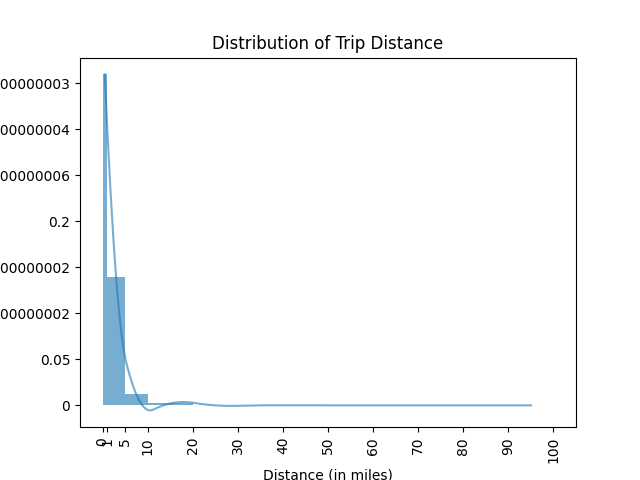

In [44]:
%matplot plt

As we can see, trips within 0 to 1 miles have the highest distribution

Now, on plotting the trip fare vs trip distance for some part of the data, we can see that fare seems to be approximately 
fixed for trip distances > 50 miles. Assuming airports pickup or dropoff to have fixed prices, we can remove the 
trips related to airport pickup and dropoff and plot the distribution of Fare Amount vs Trip distribution again.

![](farevsdist.png)

On plotting the same graph without airport trip data, we see that the cluster for distances > 50 miles still exists. Upon deeper research (visualizing the trips through a map) we can see that these longer trips are more distributed across Lower Manhattan. So, we decide to look through the training data for each of the boroughs that NY is made up of: Bronx, Brooklyn, Queens, Manhattan, Staten Island. For this, we create two new variables the represent the borough from which the pickup or dropoff happened

![](farevsdistmod.png)

### Borough-wise Analysis

In [19]:
nyc_boroughs = {
    'manhattan': {
        'min_lng': -74.0479,
        'min_lat': 40.6829,
        'max_lng': -73.9067,
        'max_lat': 40.8820
    },
    'queens': {
        'min_lng': -73.9630,
        'min_lat': 40.5431,
        'max_lng': -73.7004,
        'max_lat': 40.8007
    },
    'brooklyn': {
        'min_lng': -74.0421,
        'min_lat': 40.5707,
        'max_lng': -73.8334,
        'max_lat': 40.7395
    },
    'bronx': {
        'min_lng': -73.9339,
        'min_lat': 40.7855,
        'max_lng': -73.7654,
        'max_lat': 40.9176
    },
    'staten_island': {
        'min_lng': -74.2558,
        'min_lat': 40.4960,
        'max_lng': -74.0522,
        'max_lat': 40.6490
    }
}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
def getBorough(lat,lng):
    """
    Get the borough based on latitude and longitude
    Args:
        lat: Latitude of the place
        lng: Longitude of the place
    Returns:
        A string representing the name of the borough
    """
    locations = nyc_boroughs.keys()
    for location in locations:
        if (lat >= nyc_boroughs[location]['min_lat'] and 
            lat <= nyc_boroughs[location]['max_lat'] and 
            lng >= nyc_boroughs[location]['min_lng'] and 
            lng <= nyc_boroughs[location]['max_lng']):
            return location
    return 'others'

boroughUDF = udf(lambda a, b: getBorough(a,b))
spark.udf.register("boroughUDF", boroughUDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fc549cb4c20>

In [21]:
train_data_filtered = train_data_filtered.withColumn("pickup_borough", boroughUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude")))
train_data_filtered = train_data_filtered.withColumn("dropoff_borough", boroughUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude")))

train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+--------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|pickup_borough|dropoff_borough|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+---------

Integer encode the categorical borough variables

In [24]:
from pyspark.sql.types import IntegerType
def getBoroughMapping(borough):
    if borough == "manhattan":
        return 1
    elif borough == "queens":
        return 2
    elif borough == "brooklyn":
        return 3
    elif borough == "bronx":
        return 4
    elif borough == "staten_island":
        return 5
    else:
        return 6

bmapUDF = udf(lambda s: getBoroughMapping(s), IntegerType())
spark.udf.register("bmapUDF", bmapUDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7f2d4817ef80>

In [25]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Distribution of Pickups vs Boroughs')
plt.xlabel('Boroughs')

pickup_boroughs_numeric = train_data_filtered.withColumn("pickup_borough", bmapUDF(F.col("pickup_borough")))

hist(axes, pickup_boroughs_numeric.select(F.col("pickup_borough")))
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

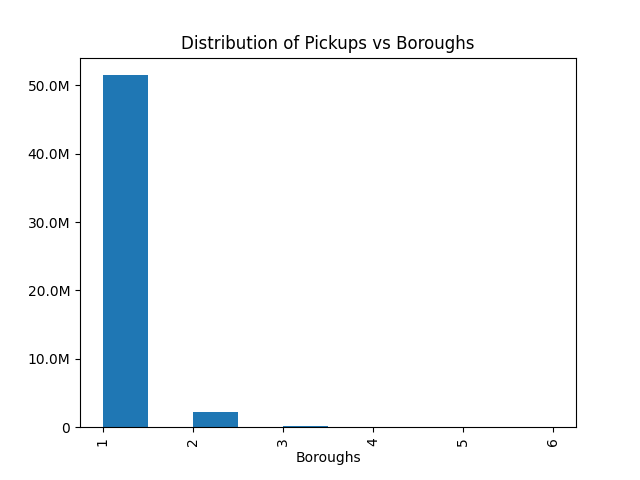

In [26]:
%matplot plt

In [50]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Distribution of Drops vs Boroughs')
plt.xlabel('Boroughs')

dropoff_boroughs_numeric = train_data_filtered.withColumn("dropoff_borough", bmapUDF(F.col("dropoff_borough")))

hist(axes, dropoff_boroughs_numeric.select(F.col("dropoff_borough")))
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

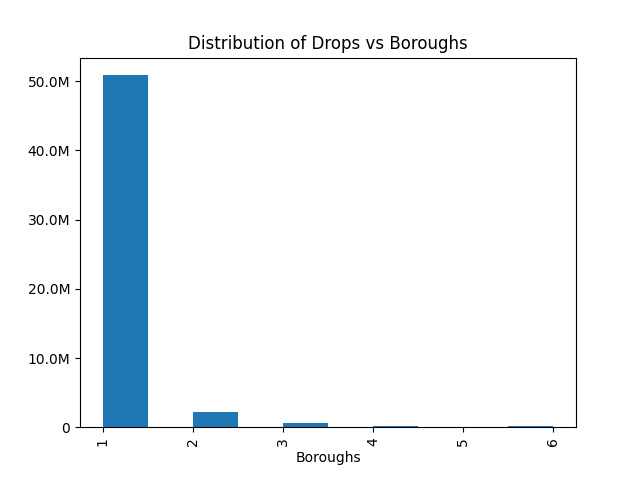

In [52]:
%matplot plt

In [ ]:
%matplot plt

As hypothesised earlier, most of the pickups and dropoffs relate to Manhattan. Next, we try to visualize the average pickup and dropoff fares for these boroughs

In [25]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Manhattan Borough")

pickup_borough_fares_manhattan = train_data_filtered.filter(F.col("pickup_borough") == "manhattan").select(F.col("fare_amount")).alias("pickup_rates")
dropoff_borough_fares_manhattan = train_data_filtered.filter(F.col("dropoff_borough") == "manhattan").select(F.col("fare_amount")).alias("dropoff_rates")
    
distplot(axes, [pickup_borough_fares_manhattan.select(F.col(("fare_amount"))), dropoff_borough_fares_manhattan.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Manhattan")
axes.legend()

plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

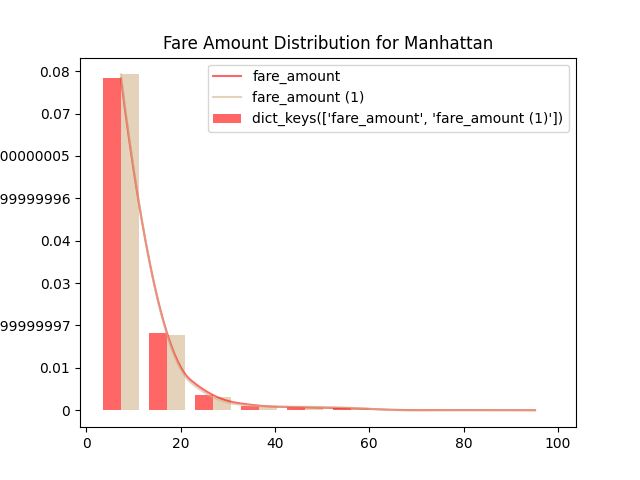

In [26]:
%matplot plt

In [27]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Bronx Borough")

pickup_borough_fares_bronx = train_data_filtered.filter(F.col("pickup_borough") == "bronx").select(F.col("fare_amount"))
dropoff_borough_fares_bronx = train_data_filtered.filter(F.col("dropoff_borough") == "bronx").select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_bronx.select(F.col(("fare_amount"))), dropoff_borough_fares_bronx.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Bronx")
axes.legend()

plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

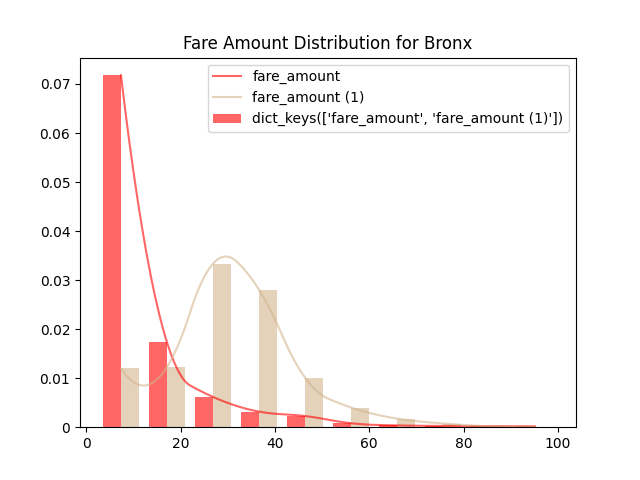

In [28]:
%matplot plt

In [29]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Queens")

pickup_borough_fares_queens = train_data_filtered.filter(F.col("pickup_borough") == "queens").select(F.col("fare_amount"))
dropoff_borough_fares_queens = train_data_filtered.filter(F.col("dropoff_borough") == "queens").select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_queens.select(F.col(("fare_amount"))), dropoff_borough_fares_queens.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Queens")
axes.legend()

plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

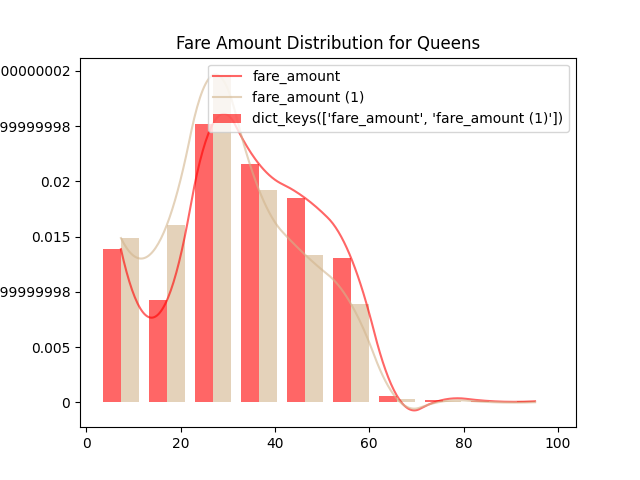

In [30]:
%matplot plt

In [31]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Brooklyn")

pickup_borough_fares_brooklyn = train_data_filtered.filter(F.col("pickup_borough") == "brooklyn").select(F.col("fare_amount"))
dropoff_borough_fares_brooklyn = train_data_filtered.filter(F.col("dropoff_borough") == "brooklyn").select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_brooklyn.select(F.col(("fare_amount"))), dropoff_borough_fares_brooklyn.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Brooklyn")
axes.legend()

plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

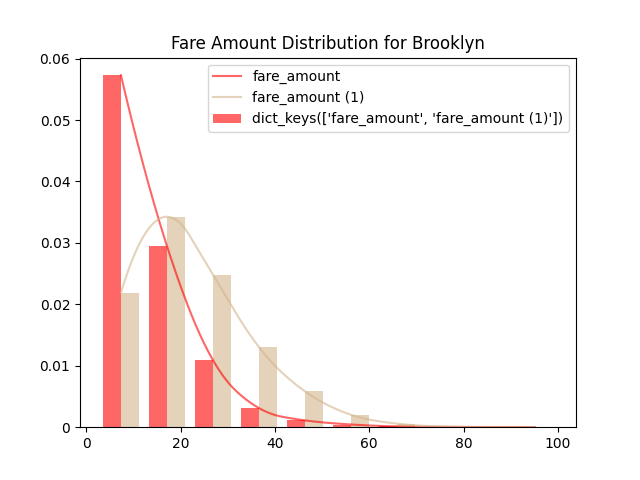

In [32]:
%matplot plt

In [33]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Staten Island")

pickup_borough_fares_staten = train_data_filtered.filter(F.col("pickup_borough") == "staten_island").select(F.col("fare_amount"))
dropoff_borough_fares_staten = train_data_filtered.filter(F.col("dropoff_borough") == "staten_island").select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_staten.select(F.col(("fare_amount"))), dropoff_borough_fares_staten.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Staten Island")
axes.legend()

plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

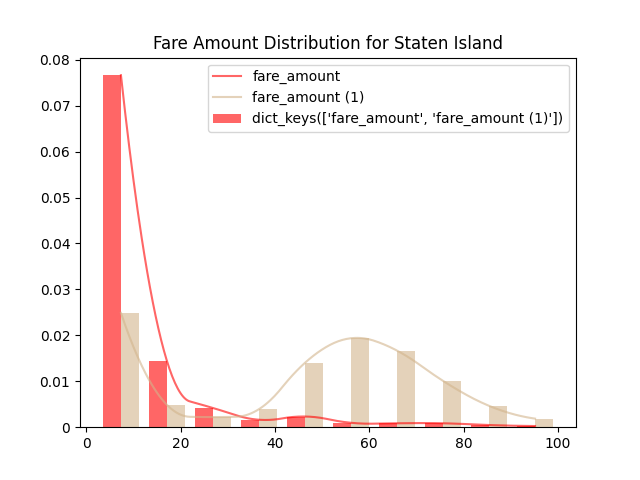

In [34]:
%matplot plt

We conclude the following from the above graphs:

1. Pickup and dropoff fare amount are almost similarly distributed for Manhattan.
2. Dropoff fare is higher for Bronx, Brooklyn and Staten Island meaning people come from far out into the Bronx, Brooklyn and Staten Island
3. For Queens, both averages are higher meaning people usually take longer trips in general

Next, we split the Manhattan borough also into two: upper and lower Manhattan and for that we introduce two new features

### Splitting Manhattan

In [22]:
lower_manhattan_boundary={
    'min_lng': -74.0194,
    'min_lat': 40.6997,           
    'max_lng': -73.9716,        
    'max_lat': 40.7427
}

def isLowerManhattan(lat,lng):
    """
    Check if lat and lng corresponds to lower manhattan
    Args:
        lat: Latitude
        lng: Longitude
    Returns:
        0 or 1 indicating whether the pick up or drop off location is in lower manhattan
    """
    if (lat >= lower_manhattan_boundary['min_lat'] and 
        lat <= lower_manhattan_boundary['max_lat'] and 
        lng >= lower_manhattan_boundary['min_lng'] and 
        lng <= lower_manhattan_boundary['max_lng']):
        return True
    else:
        return False

manhattanUDF = udf(lambda x,y : isLowerManhattan(x, y),BooleanType())
spark.udf.register("manhattanUDF", manhattanUDF)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<function <lambda> at 0x7fc549cdc200>

In [23]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_in_lower_manhattan", manhattanUDF(F.col("pickup_latitude"),\
                                                                                                  F.col("pickup_longitude")))
train_data_filtered = train_data_filtered.withColumn("is_drop_in_lower_manhattan", manhattanUDF(F.col("dropoff_latitude"),\
                                                                                                  F.col("dropoff_longitude")))

train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+--------------+---------------+----------------------------+--------------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|pickup_borough|dropoff_borough|is_pickup_in_lower_manhattan|is_drop_in_lower_manhattan|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+-------

In [39]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount - Lower Manhattan vs Other Regions in Manhattan")

lower_manhattan_pickup = train_data_filtered.filter(F.col("is_pickup_in_lower_manhattan") == True).select(F.col("fare_amount"))
other_manhattan_pickup = train_data_filtered.filter(F.col("is_pickup_in_lower_manhattan") == False).select(F.col("fare_amount"))
    
distplot(axes, [lower_manhattan_pickup.select(F.col(("fare_amount"))), other_manhattan_pickup.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Manhattan - Lower vs Other Regions")
axes.legend()

plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

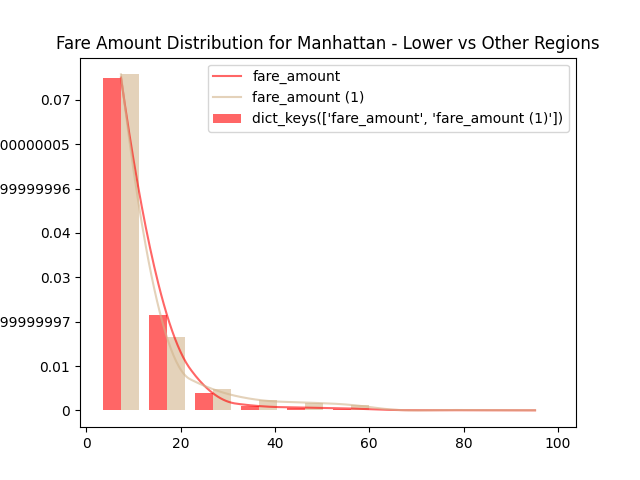

In [40]:
%matplot plt

We can see that for Lower Manhattan and Rest of Manhattan, the fare amounts are similar

# Time-based Analysis

In [53]:
trips_by_year = train_data_filtered.groupBy("pickup_year").count().toPandas()
trips_by_year = trips_by_year.sort_values(by = "pickup_year")
trips_by_year

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   pickup_year    count
6         2009  8432908
0         2010  8168683
1         2011  8504583
5         2012  8629726
2         2013  8476306
4         2014  8068283
3         2015  3777269

In [55]:
fig = plt.figure()

sns.barplot(x = "pickup_year",
            y = "count",
            data = trips_by_year).set_title("Trips per year")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Trips per year')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

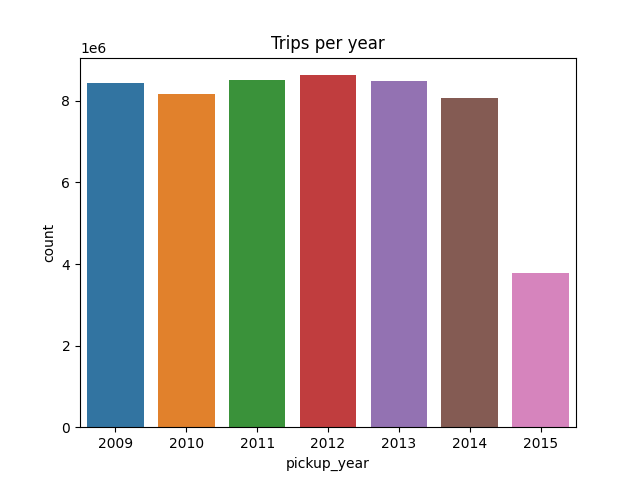

In [56]:
%matplot plt

In [57]:
trips_by_month = train_data_filtered.groupBy("pickup_month").count().toPandas()
trips_by_month = trips_by_month.sort_values(by = "pickup_month")
trips_by_month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    pickup_month    count
1              1  4817304
8              2  4545047
3              3  5069527
4              4  4984445
7              5  5082105
2              6  4862991
9              7  4098227
5              8  3856419
10             9  4118322
11            10  4368670
6             11  4107319
0             12  4147382

In [60]:
fig = plt.figure()

sns.barplot(x = "pickup_month",
            y = "count",
            data = trips_by_month).set_title("Trips per month")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Trips per month')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

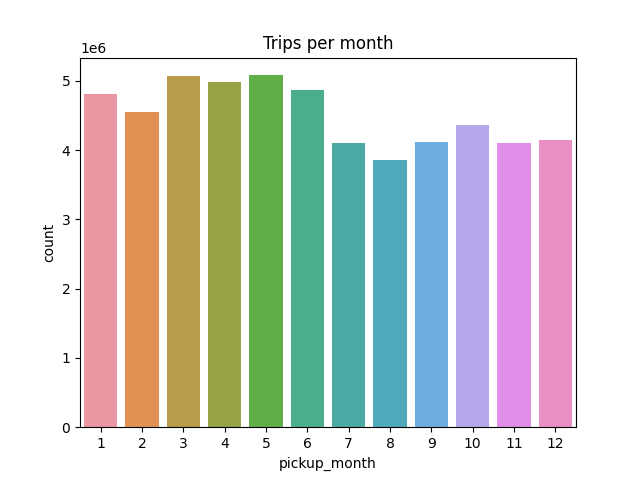

In [61]:
%matplot plt

In [67]:
trips_by_day = train_data_filtered.groupBy("pickup_day_of_week").count().toPandas()
trips_by_day = trips_by_day.sort_values(by = "pickup_day_of_week")
trips_by_day

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   pickup_day_of_week    count
0                   1  7090814
5                   2  6929640
2                   3  7573406
3                   4  7842666
4                   5  8099058
1                   6  8317144
6                   7  8205030

In [68]:
fig = plt.figure()

sns.barplot(x = "pickup_day_of_week",
            y = "count",
            data = trips_by_day).set_title("Trips per day of week (in numbers starting Sunday)")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Trips per day of week (in numbers starting Sunday)')
<string>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

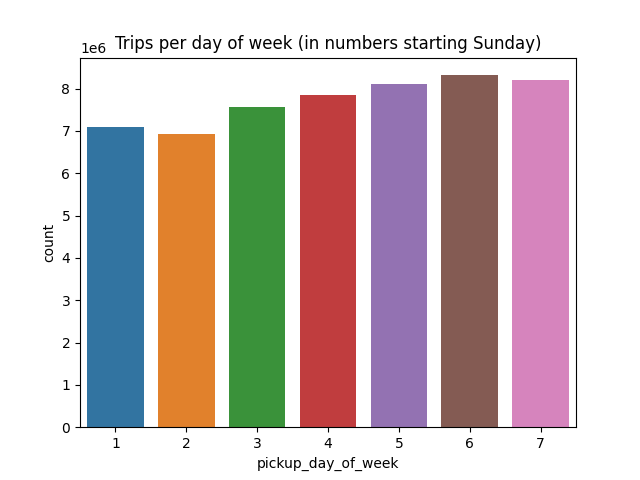

In [69]:
%matplot plt

In [70]:
trips_by_hour = train_data_filtered.groupBy("pickup_hour").count().toPandas()
trips_by_hour = trips_by_hour.sort_values(by = "pickup_hour")
trips_by_hour

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    pickup_hour    count
20            0  2139866
1             1  1584703
15            2  1181754
3             3   865742
4             4   627217
13            5   528350
2             6  1108962
19            7  1946680
5             8  2455370
22            9  2526974
23           10  2439216
6            11  2516889
0            12  2658788
17           13  2642588
10           14  2722529
14           15  2599788
11           16  2231623
18           17  2679117
16           18  3255772
7            19  3380180
12           20  3184018
9            21  3095506
21           22  3010717
8            23  2675409

In [72]:
fig = plt.figure()

sns.barplot(x = "pickup_hour",
            y = "count",
            data = trips_by_hour).set_title("Trips per hour")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Trips per hour')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

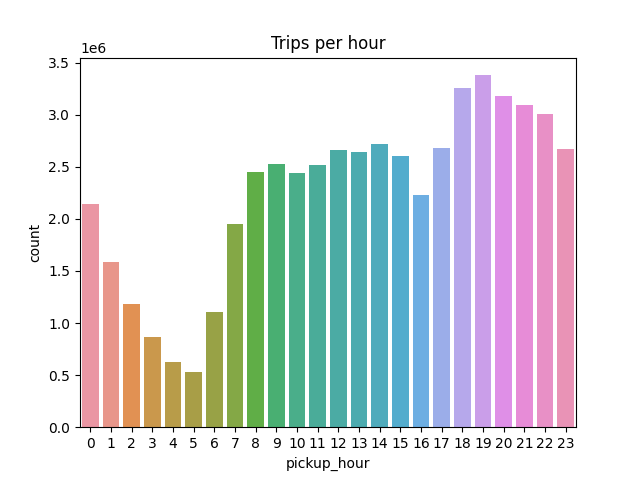

In [73]:
%matplot plt

In [90]:
avg_fares_year = train_data_filtered.select("pickup_year", "fare_amount").groupBy("pickup_year").mean().toPandas()
avg_fares_year.sort_values(by = "pickup_year", inplace = True)
avg_fares_year

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   pickup_year  avg(pickup_year)  avg(fare_amount)
6         2009            2009.0         10.036191
0         2010            2010.0         10.137589
1         2011            2011.0         10.425817
5         2012            2012.0         11.124391
2         2013            2013.0         12.506418
4         2014            2014.0         12.824710
3         2015            2015.0         12.887004

In [91]:
fig = plt.figure()

sns.barplot(x = "pickup_year",
            y = "avg(fare_amount)",
            data = avg_fares_year).set_title("Average Fares Each Year")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Average Fares Each Year')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

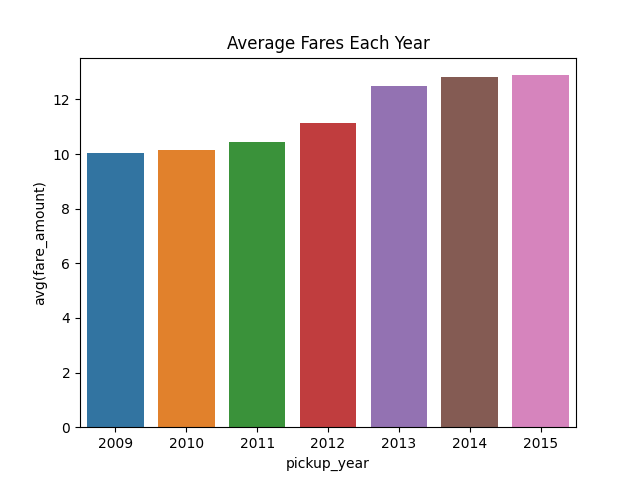

In [92]:
%matplot plt

In [93]:
avg_fares_month = train_data_filtered.select("pickup_month", "fare_amount").groupBy("pickup_month").mean().toPandas()
avg_fares_month.sort_values(by = "pickup_month", inplace = True)
avg_fares_month

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    pickup_month  avg(pickup_month)  avg(fare_amount)
1              1                1.0         10.690427
8              2                2.0         10.850605
3              3                3.0         11.135737
4              4                4.0         11.258153
7              5                5.0         11.539938
2              6                6.0         11.506472
9              7                7.0         11.067508
5              8                8.0         11.175669
10             9                9.0         11.675097
11            10               10.0         11.589168
6             11               11.0         11.506481
0             12               12.0         11.539273

In [94]:
fig = plt.figure()

sns.barplot(x = "pickup_month",
            y = "avg(fare_amount)",
            data = avg_fares_month).set_title("Average Fares Each Month")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Average Fares Each Month')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

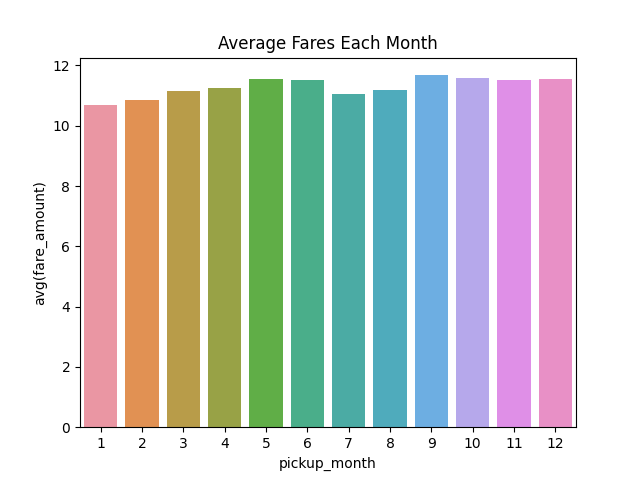

In [95]:
%matplot plt

In [96]:
avg_fares_day = train_data_filtered.select("pickup_day_of_week", "fare_amount").groupBy("pickup_day_of_week").mean().toPandas()
avg_fares_day.sort_values(by = "pickup_day_of_week", inplace = True)
avg_fares_day

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   pickup_day_of_week  avg(pickup_day_of_week)  avg(fare_amount)
0                   1                      1.0         11.583543
5                   2                      2.0         11.320434
2                   3                      3.0         11.138204
3                   4                      4.0         11.257655
4                   5                      5.0         11.441898
1                   6                      6.0         11.368184
6                   7                      7.0         10.947569

In [97]:
fig = plt.figure()

sns.barplot(x = "pickup_day_of_week",
            y = "avg(fare_amount)",
            data = avg_fares_day).set_title("Average Fares for Each Day (starting Sunday in numbers)")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Average Fares for Each Day (starting Sunday in numbers)')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

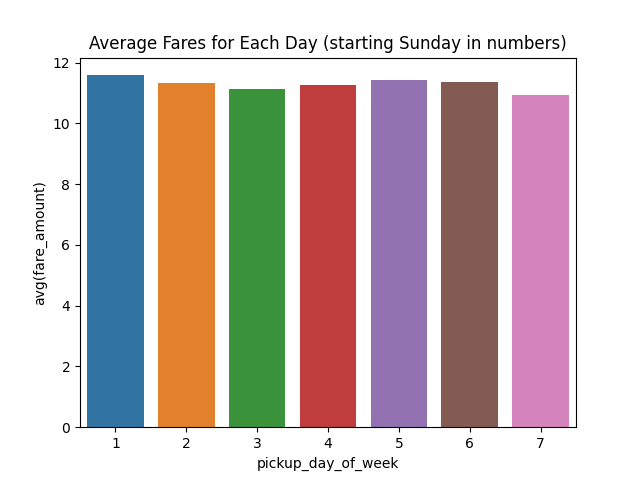

In [98]:
%matplot plt

In [99]:
avg_fares_hour = train_data_filtered.select("pickup_hour", "fare_amount").groupBy("pickup_hour").mean().toPandas()
avg_fares_hour.sort_values(by = "pickup_hour", inplace = True)
avg_fares_hour

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    pickup_hour  avg(pickup_hour)  avg(fare_amount)
20            0               0.0         11.622322
1             1               1.0         11.349003
15            2               2.0         11.331435
3             3               3.0         11.786527
4             4               4.0         13.521306
13            5               5.0         15.098579
2             6               6.0         12.128896
19            7               7.0         10.955931
5             8               8.0         10.877159
22            9               9.0         10.831554
23           10              10.0         10.885888
6            11              11.0         11.078682
0            12              12.0         11.092259
17           13              13.0         11.481311
10           14              14.0         11.827846
14           15              15.0         11.917005
11           16              16.0         11.822765
18           17              17.0         11.445367
16          

In [100]:
fig = plt.figure()

sns.barplot(x = "pickup_hour",
            y = "avg(fare_amount)",
            data = avg_fares_hour).set_title("Average Fares for Each Hour")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Text(0.5, 1.0, 'Average Fares for Each Hour')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

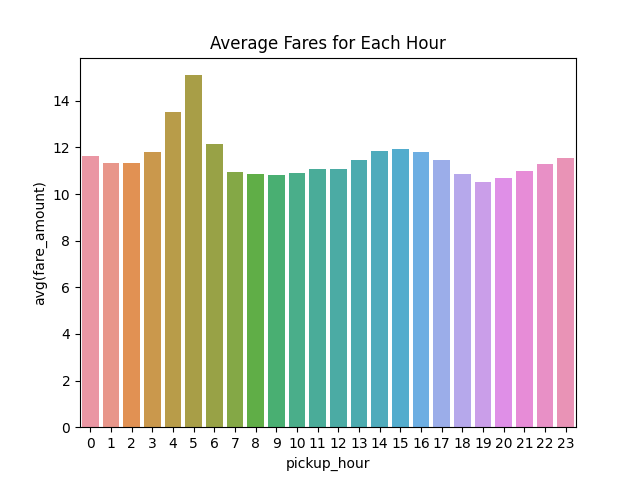

In [101]:
%matplot plt

# Building a ML Pipeline

In [109]:
train_data_filtered.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- key: timestamp (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day_of_week: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- is_pickup_JFK: boolean (nullable = true)
 |-- is_dropoff_JFK: boolean (nullable = true)
 |-- is_pickup_EWR: boolean (nullable = true)
 |-- is_dropoff_EWR: boolean (nullable = true)
 |-- is_pickup_LaGuardia: boolean (nullable = true)
 |-- is_dropoff_LaGuardia: boolean (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_borough:

First, we drop the 'pickup_datetime' and 'pickup_date' columns because of their type. Next, we encode the 'pickup_borough' and 'dropoff_borough' columns

In [116]:
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator, VectorAssembler
from pyspark.ml import Pipeline

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
train_data_filtered = train_data_filtered.drop("pickup_datetime", "pickup_date")

### Encoding data and removing un-encoded columns

In [118]:
# create object of StringIndexer class and specify input and output column
SI_pickup = StringIndexer(inputCol='pickup_borough',outputCol='pickup_borough_encoded')
SI_dropoff = StringIndexer(inputCol='dropoff_borough',outputCol='dropoff_borough_encoded')

# transform the data
train_data_filtered = SI_pickup.fit(train_data_filtered).transform(train_data_filtered)
train_data_filtered = SI_dropoff.fit(train_data_filtered).transform(train_data_filtered)

# create object and specify input and output column
OHE = OneHotEncoderEstimator(inputCols=['pickup_borough_encoded', 'dropoff_borough_encoded'],\
                             outputCols=['pickup_borough_OHE', 'dropoff_borough_OHE'])

# transform the data
train_data_filtered = OHE.fit(train_data_filtered).transform(train_data_filtered)

train_data_filtered = train_data_filtered.drop("pickup_borough", "dropoff_borough", "pickup_borough_encoded", 
                                               "dropoff_borough_encoded")

print(len(train_data_filtered.columns))
train_data_filtered.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

23
+-------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+----------------------------+--------------------------+------------------+-------------------+
|                key|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|is_pickup_in_lower_manhattan|is_drop_in_lower_manhattan|pickup_borough_OHE|dropoff_borough_OHE|
+-------------------+-----------+----------------+---------------+-----------------+----------------+---------------+----------+-----------+------------------+------------+-----------+-------------+---

In [135]:
train_data_filtered = train_data_filtered.drop("key")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### VectorAssembling

In [155]:
featureColumns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', \
                  'pickup_day', 'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'pickup_year', 'is_pickup_JFK', \
                  'is_dropoff_JFK', 'is_pickup_EWR', 'is_dropoff_EWR', 'is_pickup_LaGuardia', 'is_dropoff_LaGuardia', \
                  'trip_distance', 'is_pickup_in_lower_manhattan', 'is_drop_in_lower_manhattan', 'pickup_borough_OHE', \
                  'dropoff_borough_OHE']

assembler = VectorAssembler(inputCols= featureColumns, outputCol="features")

full_set = assembler.transform(train_data_filtered)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [156]:
full_set.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------------+---------------+-----------------+----------------+---------------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+----------------------------+--------------------------+------------------+-------------------+--------------------+
|fare_amount|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|is_pickup_in_lower_manhattan|is_drop_in_lower_manhattan|pickup_borough_OHE|dropoff_borough_OHE|            features|
+-----------+----------------+---------------+-----------------+----------------+---------------+----------+-----------+------------------+------------+-----------+-------------+--------------+---------

### Split train and test set

In [157]:
train_set, test_set = full_set.randomSplit([0.9, 0.1], seed=0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [158]:
print(test_set.count(), len(test_set.columns))
print(train_set.count(), len(train_set.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5406428 23
48651330 23

### Random Forest

In [159]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

rf = RandomForestRegressor(labelCol="fare_amount", featuresCol= "features")
model = rf.fit(train_set)

predictions = model.transform(test_set)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [160]:
predictions.select("prediction", "fare_amount").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----------+
|        prediction|fare_amount|
+------------------+-----------+
| 18.42720878127786|        2.5|
|11.877214852627052|        2.5|
| 16.08345399361932|        2.5|
| 14.91263213808153|        2.5|
| 8.857089332423525|        2.5|
+------------------+-----------+
only showing top 5 rows

In [162]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="fare_amount",metricName="rmse")
print("RMSE Error on test set: ", evaluator.evaluate(predictions))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE Error on test set:  4.4201998172430255

### Decision Tree

In [163]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [164]:
dt = DecisionTreeRegressor(labelCol="fare_amount", featuresCol= "features")
model = dt.fit(train_set)

predictions = model.transform(test_set)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [165]:
predictions.select("prediction", "fare_amount").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----------+
|        prediction|fare_amount|
+------------------+-----------+
|26.292193752552055|        2.5|
|26.292193752552055|        2.5|
|26.292193752552055|        2.5|
|26.292193752552055|        2.5|
|26.292193752552055|        2.5|
+------------------+-----------+
only showing top 5 rows

In [166]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="fare_amount",metricName="rmse")
print("RMSE Error on test set: ", evaluator.evaluate(predictions))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE Error on test set:  4.281480982734822